In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import ceil, log2
from sklearn.ensemble import RandomForestClassifier
import openml
from simple_model import  ConformalPredictor, ConformalRankingPredictor, ClassifierModel, LabelRankingModel
import matplotlib.pyplot as plt

In [2]:
def evaluate_models(dataset_id):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(
        target=dataset.default_target_attribute, dataset_format="dataframe"
    )

    # Automatically identify categorical and numerical columns
    categorical_features = X.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

    num_classes = len(np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1
    )

    # Encode labels
    le = LabelEncoder()

    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # Preprocessing for numerical data: Impute missing values, then scale
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
        ]
    )

    # Preprocessing for categorical data: Impute missing values, then one-hot encode
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    if not isinstance(X_train, np.ndarray):
        X_train = X_train.toarray()
    if not isinstance(y_train, np.ndarray):
        y_train = y_train.toarray()

    # clf = ClassifierModel(input_dim = X_train.shape[1], hidden_dim=16, output_dim=y.max()+1)
    rf = RandomForestClassifier()

    clf = ClassifierModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)
    rank = LabelRankingModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)

    num_classes = len(np.unique(y_train))

    batch_size_clf = 32
    val_frac = 0.2
    cal_frac = 1/3
    num_epochs = 35
    learning_rate = 0.01

    cp_net = ConformalPredictor(clf, alpha=0.05)
    cp_rf = ConformalPredictor(rf, alpha=0.05)
    cp_rank = ConformalPredictor(rank, alpha=0.05)

    cp_net.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rank.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rf.fit(X_train, y_train, cal_size=cal_frac)

    if not isinstance(X_test, np.ndarray):
        X_test = X_test.toarray()
    if not isinstance(y_test, np.ndarray):
        y_test = y_test.toarray()

    def evaluate_method(method):
        pred_sets = method.predict_set(X_test)
        y_test_model = method.model.predict(X_test)
        coverage = np.mean([y_test[i] in pred_sets[i] for i in range(len(y_test))])
        efficiency = np.mean([len(pred_sets[i]) for i in range(len(y_test))])
        print(f"Accuracy {accuracy_score(y_test_model, y_test)}")
        print(f"Coverage {coverage} efficiency {efficiency}")

    # coverage_clf = np.mean([y_test[i] in pred_sets_clf[i] for i in range(len(y_test))])
    # efficiency_clf = np.mean([len(pred_sets_clf[i]) for i in range(len(y_test))])

    print("Random Forest")
    evaluate_method(cp_rf)
    print("\nClassifier Network")
    evaluate_method(cp_net)
    print("\nRanking Network")
    evaluate_method(cp_rank)
for dataset_id in [61, 187, 15, 31, 4534, 1461]:
    print(f"\n\nDataset: {dataset_id}")
    evaluate_models(dataset_id)




Dataset: 61


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9666666666666667
Coverage 1.0 efficiency 1.0333333333333334

Classifier Network
Accuracy 0.9666666666666667
Coverage 1.0 efficiency 1.1

Ranking Network
Accuracy 0.9666666666666667
Coverage 0.8 efficiency 0.8333333333333334


Dataset: 187


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9722222222222222
Coverage 1.0 efficiency 1.0555555555555556

Classifier Network
Accuracy 1.0
Coverage 0.9722222222222222 efficiency 0.9722222222222222

Ranking Network
Accuracy 1.0
Coverage 1.0 efficiency 1.0277777777777777


Dataset: 15


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9857142857142858
Coverage 0.9571428571428572 efficiency 0.9642857142857143

Classifier Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0

Ranking Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0


Dataset: 31


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.775
Coverage 0.98 efficiency 1.74

Classifier Network
Accuracy 0.75
Coverage 0.955 efficiency 1.57

Ranking Network
Accuracy 0.75
Coverage 0.955 efficiency 1.61


Dataset: 4534


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9651741293532339
Coverage 0.9470827679782904 efficiency 0.9710538218000905

Classifier Network
Accuracy 0.9493441881501583
Coverage 0.947535052012664 efficiency 0.9959294436906377

Ranking Network
Accuracy 0.9434644957033017
Coverage 0.9407507914970602 efficiency 0.9886928991406604


Dataset: 1461


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9016919163994249
Coverage 0.9524494083821741 efficiency 1.1152272475948248

Classifier Network
Accuracy 0.9026871613402632
Coverage 0.9554351432046887 efficiency 1.1266172730288622

Ranking Network
Accuracy 0.9073316377308416
Coverage 0.9526705739245825 efficiency 1.1195399756717903


In [3]:
from simple_model import LabelPairDataset

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3)
num_classes = len(np.unique(y))


In [5]:
from simple_model import LabelRankingModel
model = LabelRankingModel(input_dim=X_train.shape[1],hidden_dim=16, output_dim=3)
model.fit(X_train,y_train,num_classes=3, random_state=1, batch_size=32, num_epochs=250,patience=250)

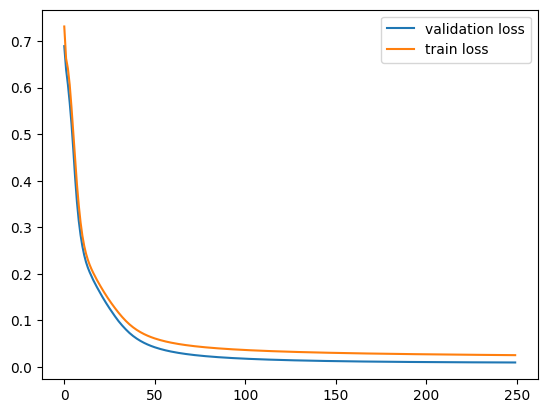

In [6]:
plt.plot(np.arange(len(model.val_losses)), model.val_losses, label="validation loss")
plt.plot(np.arange(len(model.train_losses)), model.train_losses, label="train loss")
plt.legend()
plt.show()

In [7]:
y_pred = model.predict(X_test)

In [8]:
accuracy_score(y_pred,y_test)

0.96

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

# Training and test data loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# # Step 2: Load the pre-trained ResNet18 model
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features

# # Modify the final layer for 10 classes (CIFAR-10)
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

# # Step 3: Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 4: Train the model
# epochs = 5
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in trainloader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')

# # Step 5: Evaluate the model on the test set
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in testloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


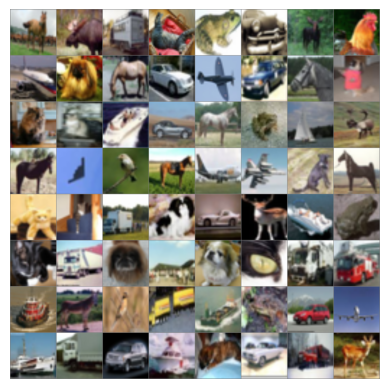

horse deer truck cat


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image (reverse the normalization)
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C)
    plt.axis('off')  # Turn off axis
    plt.show()

# Step 3: Get a batch of images and display them
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Get a batch of images and labels

# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))  # Display the images in a grid

# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [11]:

probs = np.load("data/cifar10h-probs.npy")
counts = np.load("data/cifar10h-counts.npy")


In [12]:
def show_pic_and_probs(k):
    df = pd.DataFrame({'classes': classes, 'counts': counts[k], 'probabilities': probs[k]})
    imshow(testset[k][0])
    display(df)

In [13]:
epsilon = 1e-10
entropy = -np.sum(probs * np.log2(probs + epsilon), axis=1)
high_confusion = np.argsort(entropy)[::-1][:5]
high_confusion

array([6750, 8153, 6792,   86, 2232])

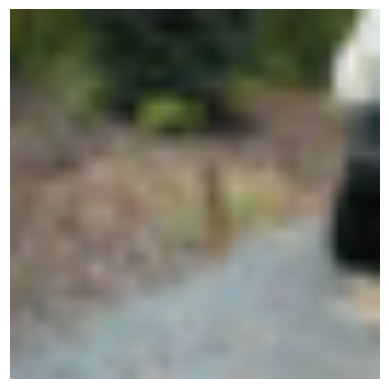

,classes,counts,probabilities
0,plane,1,0.019231
1,car,3,0.057692
2,bird,6,0.115385
3,cat,6,0.115385
4,deer,9,0.173077
5,dog,9,0.173077
6,frog,13,0.250000
7,horse,0,0.000000
8,ship,3,0.057692
9,truck,2,0.038462


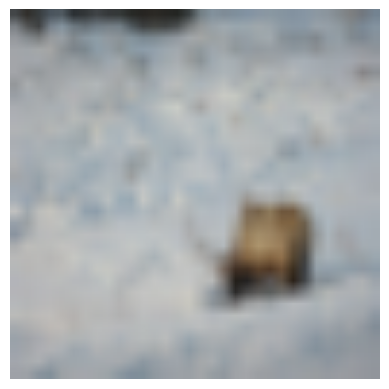

,classes,counts,probabilities
0,plane,0,0.00
1,car,4,0.08
2,bird,4,0.08
3,cat,8,0.16
4,deer,19,0.38
5,dog,10,0.20
6,frog,2,0.04
7,horse,0,0.00
8,ship,0,0.00
9,truck,3,0.06


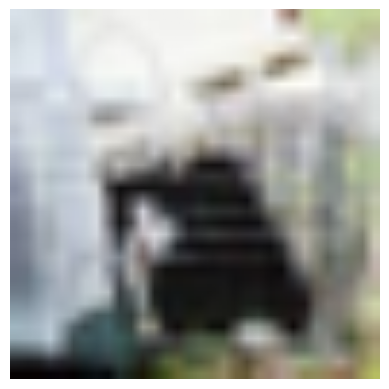

,classes,counts,probabilities
0,plane,4,0.08
1,car,1,0.02
2,bird,1,0.02
3,cat,16,0.32
4,deer,0,0.00
5,dog,6,0.12
6,frog,0,0.00
7,horse,0,0.00
8,ship,11,0.22
9,truck,11,0.22


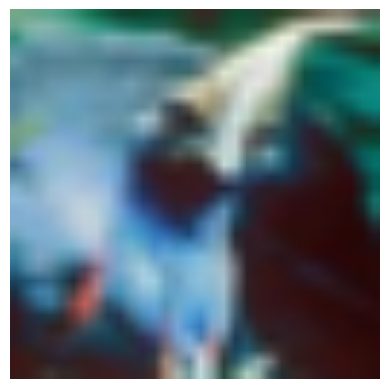

,classes,counts,probabilities
0,plane,0,0.000000
1,car,1,0.019231
2,bird,25,0.480769
3,cat,3,0.057692
4,deer,2,0.038462
5,dog,5,0.096154
6,frog,6,0.115385
7,horse,0,0.000000
8,ship,8,0.153846
9,truck,2,0.038462


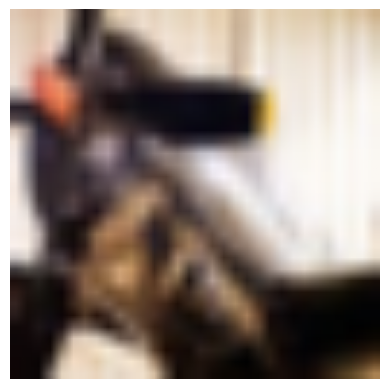

,classes,counts,probabilities
0,plane,24,0.470588
1,car,2,0.039216
2,bird,8,0.156863
3,cat,9,0.176471
4,deer,0,0.000000
5,dog,3,0.058824
6,frog,2,0.039216
7,horse,2,0.039216
8,ship,1,0.019608
9,truck,0,0.000000


In [14]:
for k in high_confusion:
    show_pic_and_probs(k)

In [22]:
from scipy.stats import kendalltau
kendalltau([1,2,3], [6,5,4])

SignificanceResult(statistic=-1.0, pvalue=0.3333333333333333)

(array([7.713e+03, 1.048e+03, 5.810e+02, 3.540e+02, 1.500e+02, 9.300e+01,
        3.700e+01, 2.000e+01, 3.000e+00, 1.000e+00]),
 array([-1.44269516e-10,  2.86017642e-01,  5.72035284e-01,  8.58052926e-01,
         1.14407057e+00,  1.43008821e+00,  1.71610585e+00,  2.00212349e+00,
         2.28814114e+00,  2.57415878e+00,  2.86017642e+00]),
 <BarContainer object of 10 artists>)

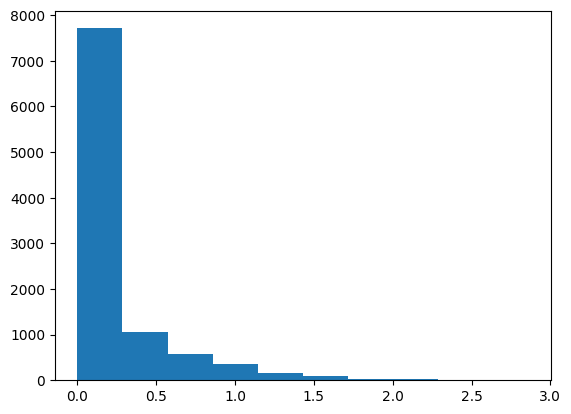

In [15]:
plt.hist(entropy)

In [16]:
from simple_model import LabelPairDataset

In [17]:
type(testset[0][1])

int

In [18]:
pair_ds = LabelPairDataset(X,y)

TypeError: LabelPairDataset.__init__() missing 1 required positional argument: 'num_classes'